## Neural network predicting 1 future point

In [13]:
#! git clone https://github.com/crowdbotp/OpenTraj.git
#! pip install pykalman

In [14]:
import os
import sys
sys.path.insert(0, os.path.abspath(os.getcwd()) + '/OpenTraj/opentraj/') # Anaconda python can't find the toolkit path without this for some reason

from toolkit.loaders.loader_edinburgh import load_edinburgh
from matplotlib import pyplot as plt
import numpy as np
np.random.seed(42)

## Data preparation

In [15]:
opentraj_root = './OpenTraj/'
selected_day = '01Sep' # 3 days of data in total, ['01Jul', '01Aug', '01Sep']
edinburgh_path = os.path.join(opentraj_root, 'datasets/Edinburgh/annotations', 'tracks.%s.txt' % selected_day)
traj_dataset = load_edinburgh(edinburgh_path, title="Edinburgh", 
                              use_kalman=False, scene_id=selected_day, sampling_rate=4)

/Users/kriis/miniforge3/envs/tensorflow_m1/lib/python3.9/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


reading:./OpenTraj/datasets/Edinburgh/annotations/tracks.01Sep.txt


100%|█████████████████████████████████████████████████████| 2342/2342 [01:10<00:00, 33.11it/s]


Warning! too big dt in [Edinburgh]
finish


In [16]:
data = traj_dataset.data
NUM_OF_STEPS = 5

# Removing any agents which don't have enough steps for model fitting and predicting
agent_ids = data.agent_id.unique()
for agent_id in agent_ids:
    if len(data[data.agent_id == agent_id]) < 2*NUM_OF_STEPS:
        data = data[data.agent_id != agent_id]
agent_ids = data.agent_id.unique()

In [17]:
# 'Normalize' the data so that all trajectories will begin at x=0, y=0
for agent_id in agent_ids:
    first_x = data[data.agent_id == agent_id]['pos_x'].iloc[0]
    first_y = data[data.agent_id == agent_id]['pos_y'].iloc[0]
    
    data.loc[data.agent_id == agent_id, 'pos_x'] = data[data.agent_id == agent_id]['pos_x'] - first_x
    data.loc[data.agent_id == agent_id, 'pos_y'] = data[data.agent_id == agent_id]['pos_y'] - first_y

In [18]:
# Select the useful columns from the dataset
data = data[['index', 'agent_id', 'pos_x', 'pos_y']]

In [19]:
from sklearn.model_selection import train_test_split
train_agent_ids, test_agent_ids = train_test_split(agent_ids, test_size=0.2)

### Helper functions

In [20]:
def create_dataset(data, agent_ids):
    dataX, dataY = [], []
    for agent_id in agent_ids:
        x = data[data['agent_id'] == agent_id].iloc[:5][['pos_x', 'pos_y']]
        y = data[data['agent_id'] == agent_id].iloc[5][['pos_x', 'pos_y']]
        dataX.append(x)
        dataY.append(y)
    return np.array(dataX), np.array(dataY)
    
def calculate_error(pred_x, pred_y, test_x, test_y):
    
    # FDE
    final_displacement_x = pred_x[-1] - test_x[-1]
    final_displacement_y = pred_y[-1] - test_y[-1]
    FDE = np.sqrt(final_displacement_x**2 + final_displacement_y**2)
    
    # MSE
    abs_error_x = pred_x - test_x
    abs_error_y = pred_y - test_y
    
    MSE = np.mean(np.square(abs_error_x)) + np.mean(np.square(abs_error_y))
    
    return FDE, MSE

## Experiment

In [21]:
train = create_dataset(data, train_agent_ids)
test = create_dataset(data, test_agent_ids)

In [24]:
from keras.models import Model
from keras.layers import *    
from keras import backend as K

def RMSE(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true))) 

inp = Input((5,2))

x = Flatten()(inp)

x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
x = Dense(16, activation='relu')(x)
x = Dense(16, activation='relu')(x)

out1 = Dense(1, activation='linear')(x)    
out2 = Dense(1, activation='linear')(x)

model = Model(inputs=inp, outputs=[out1,out2])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss = RMSE)

In [25]:
sep_y_train_data = np.hsplit(train[1], 2) # separate the y data into pieces to only provide 1 point as NN output
model.fit(train[0], [sep_y_train_data[0], sep_y_train_data[1]], epochs=400, batch_size=16, verbose=2)

Epoch 1/400


2022-01-07 13:40:52.414893: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


99/99 - 1s - loss: 2.7854 - dense_16_loss: 1.1365 - dense_17_loss: 1.6489 - 1s/epoch - 11ms/step
Epoch 2/400
99/99 - 0s - loss: 0.7466 - dense_16_loss: 0.3981 - dense_17_loss: 0.3485 - 490ms/epoch - 5ms/step
Epoch 3/400
99/99 - 0s - loss: 0.6182 - dense_16_loss: 0.3197 - dense_17_loss: 0.2985 - 486ms/epoch - 5ms/step
Epoch 4/400
99/99 - 0s - loss: 0.5739 - dense_16_loss: 0.2862 - dense_17_loss: 0.2877 - 484ms/epoch - 5ms/step
Epoch 5/400
99/99 - 0s - loss: 0.5451 - dense_16_loss: 0.2730 - dense_17_loss: 0.2721 - 484ms/epoch - 5ms/step
Epoch 6/400
99/99 - 0s - loss: 0.5316 - dense_16_loss: 0.2572 - dense_17_loss: 0.2744 - 483ms/epoch - 5ms/step
Epoch 7/400
99/99 - 0s - loss: 0.5168 - dense_16_loss: 0.2533 - dense_17_loss: 0.2636 - 482ms/epoch - 5ms/step
Epoch 8/400
99/99 - 0s - loss: 0.5053 - dense_16_loss: 0.2445 - dense_17_loss: 0.2608 - 489ms/epoch - 5ms/step
Epoch 9/400
99/99 - 0s - loss: 0.5001 - dense_16_loss: 0.2390 - dense_17_loss: 0.2612 - 496ms/epoch - 5ms/step
Epoch 10/400
99

Epoch 75/400
99/99 - 0s - loss: 0.3915 - dense_16_loss: 0.1865 - dense_17_loss: 0.2051 - 477ms/epoch - 5ms/step
Epoch 76/400
99/99 - 0s - loss: 0.4086 - dense_16_loss: 0.1968 - dense_17_loss: 0.2118 - 476ms/epoch - 5ms/step
Epoch 77/400
99/99 - 0s - loss: 0.3972 - dense_16_loss: 0.1929 - dense_17_loss: 0.2043 - 475ms/epoch - 5ms/step
Epoch 78/400
99/99 - 0s - loss: 0.4047 - dense_16_loss: 0.1936 - dense_17_loss: 0.2111 - 476ms/epoch - 5ms/step
Epoch 79/400
99/99 - 0s - loss: 0.4072 - dense_16_loss: 0.1976 - dense_17_loss: 0.2096 - 495ms/epoch - 5ms/step
Epoch 80/400
99/99 - 1s - loss: 0.3995 - dense_16_loss: 0.1890 - dense_17_loss: 0.2105 - 519ms/epoch - 5ms/step
Epoch 81/400
99/99 - 0s - loss: 0.3923 - dense_16_loss: 0.1862 - dense_17_loss: 0.2062 - 493ms/epoch - 5ms/step
Epoch 82/400
99/99 - 0s - loss: 0.3975 - dense_16_loss: 0.1893 - dense_17_loss: 0.2083 - 476ms/epoch - 5ms/step
Epoch 83/400
99/99 - 0s - loss: 0.3952 - dense_16_loss: 0.1900 - dense_17_loss: 0.2052 - 475ms/epoch - 5

Epoch 148/400
99/99 - 0s - loss: 0.3462 - dense_16_loss: 0.1656 - dense_17_loss: 0.1805 - 497ms/epoch - 5ms/step
Epoch 149/400
99/99 - 0s - loss: 0.3526 - dense_16_loss: 0.1657 - dense_17_loss: 0.1868 - 482ms/epoch - 5ms/step
Epoch 150/400
99/99 - 0s - loss: 0.3584 - dense_16_loss: 0.1676 - dense_17_loss: 0.1907 - 483ms/epoch - 5ms/step
Epoch 151/400
99/99 - 0s - loss: 0.3535 - dense_16_loss: 0.1611 - dense_17_loss: 0.1923 - 485ms/epoch - 5ms/step
Epoch 152/400
99/99 - 0s - loss: 0.3617 - dense_16_loss: 0.1673 - dense_17_loss: 0.1944 - 481ms/epoch - 5ms/step
Epoch 153/400
99/99 - 0s - loss: 0.3572 - dense_16_loss: 0.1691 - dense_17_loss: 0.1880 - 479ms/epoch - 5ms/step
Epoch 154/400
99/99 - 1s - loss: 0.3518 - dense_16_loss: 0.1644 - dense_17_loss: 0.1874 - 575ms/epoch - 6ms/step
Epoch 155/400
99/99 - 1s - loss: 0.3438 - dense_16_loss: 0.1598 - dense_17_loss: 0.1840 - 708ms/epoch - 7ms/step
Epoch 156/400
99/99 - 1s - loss: 0.3496 - dense_16_loss: 0.1589 - dense_17_loss: 0.1907 - 698ms/

Epoch 221/400
99/99 - 1s - loss: 0.3357 - dense_16_loss: 0.1606 - dense_17_loss: 0.1751 - 513ms/epoch - 5ms/step
Epoch 222/400
99/99 - 1s - loss: 0.3332 - dense_16_loss: 0.1577 - dense_17_loss: 0.1755 - 509ms/epoch - 5ms/step
Epoch 223/400
99/99 - 0s - loss: 0.3295 - dense_16_loss: 0.1549 - dense_17_loss: 0.1746 - 478ms/epoch - 5ms/step
Epoch 224/400
99/99 - 0s - loss: 0.3306 - dense_16_loss: 0.1532 - dense_17_loss: 0.1774 - 488ms/epoch - 5ms/step
Epoch 225/400
99/99 - 0s - loss: 0.3292 - dense_16_loss: 0.1534 - dense_17_loss: 0.1758 - 473ms/epoch - 5ms/step
Epoch 226/400
99/99 - 0s - loss: 0.3260 - dense_16_loss: 0.1480 - dense_17_loss: 0.1780 - 486ms/epoch - 5ms/step
Epoch 227/400
99/99 - 0s - loss: 0.3266 - dense_16_loss: 0.1538 - dense_17_loss: 0.1728 - 479ms/epoch - 5ms/step
Epoch 228/400
99/99 - 0s - loss: 0.3283 - dense_16_loss: 0.1574 - dense_17_loss: 0.1709 - 476ms/epoch - 5ms/step
Epoch 229/400
99/99 - 0s - loss: 0.3254 - dense_16_loss: 0.1511 - dense_17_loss: 0.1742 - 488ms/

Epoch 294/400
99/99 - 0s - loss: 0.3098 - dense_16_loss: 0.1477 - dense_17_loss: 0.1621 - 481ms/epoch - 5ms/step
Epoch 295/400
99/99 - 0s - loss: 0.3092 - dense_16_loss: 0.1464 - dense_17_loss: 0.1628 - 476ms/epoch - 5ms/step
Epoch 296/400
99/99 - 0s - loss: 0.3115 - dense_16_loss: 0.1484 - dense_17_loss: 0.1631 - 479ms/epoch - 5ms/step
Epoch 297/400
99/99 - 0s - loss: 0.3065 - dense_16_loss: 0.1476 - dense_17_loss: 0.1589 - 476ms/epoch - 5ms/step
Epoch 298/400
99/99 - 0s - loss: 0.3156 - dense_16_loss: 0.1513 - dense_17_loss: 0.1643 - 478ms/epoch - 5ms/step
Epoch 299/400
99/99 - 0s - loss: 0.3172 - dense_16_loss: 0.1520 - dense_17_loss: 0.1652 - 477ms/epoch - 5ms/step
Epoch 300/400
99/99 - 0s - loss: 0.3152 - dense_16_loss: 0.1543 - dense_17_loss: 0.1609 - 478ms/epoch - 5ms/step
Epoch 301/400
99/99 - 0s - loss: 0.3234 - dense_16_loss: 0.1543 - dense_17_loss: 0.1692 - 478ms/epoch - 5ms/step
Epoch 302/400
99/99 - 0s - loss: 0.3024 - dense_16_loss: 0.1428 - dense_17_loss: 0.1596 - 475ms/

Epoch 367/400
99/99 - 0s - loss: 0.3035 - dense_16_loss: 0.1406 - dense_17_loss: 0.1628 - 478ms/epoch - 5ms/step
Epoch 368/400
99/99 - 0s - loss: 0.2971 - dense_16_loss: 0.1393 - dense_17_loss: 0.1577 - 476ms/epoch - 5ms/step
Epoch 369/400
99/99 - 0s - loss: 0.2972 - dense_16_loss: 0.1395 - dense_17_loss: 0.1577 - 477ms/epoch - 5ms/step
Epoch 370/400
99/99 - 0s - loss: 0.3017 - dense_16_loss: 0.1432 - dense_17_loss: 0.1585 - 476ms/epoch - 5ms/step
Epoch 371/400
99/99 - 0s - loss: 0.2982 - dense_16_loss: 0.1424 - dense_17_loss: 0.1558 - 481ms/epoch - 5ms/step
Epoch 372/400
99/99 - 0s - loss: 0.2973 - dense_16_loss: 0.1420 - dense_17_loss: 0.1553 - 477ms/epoch - 5ms/step
Epoch 373/400
99/99 - 0s - loss: 0.3040 - dense_16_loss: 0.1462 - dense_17_loss: 0.1578 - 480ms/epoch - 5ms/step
Epoch 374/400
99/99 - 0s - loss: 0.3013 - dense_16_loss: 0.1435 - dense_17_loss: 0.1578 - 477ms/epoch - 5ms/step
Epoch 375/400
99/99 - 0s - loss: 0.2995 - dense_16_loss: 0.1413 - dense_17_loss: 0.1582 - 475ms/

In [26]:
trainScore = model.evaluate(train[0], [sep_y_train_data[0], sep_y_train_data[1]], verbose=0)
print('Train Score: %.2f' % (trainScore[0]))

sep_y_test_data = np.hsplit(test[1], 2)
testScore = model.evaluate(test[0], [sep_y_test_data[0], sep_y_test_data[1]], verbose=0)
print('Test Score: %.2f' % (testScore[0]))

2022-01-07 13:44:09.938711: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Train Score: 0.31
Test Score: 0.50


## Predicting on train data and plotting

2022-01-07 13:44:10.343665: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


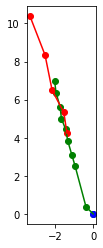

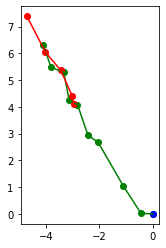

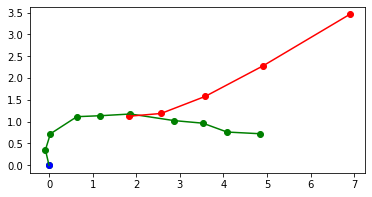

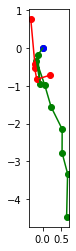

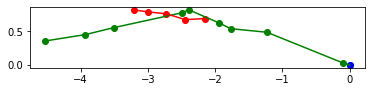

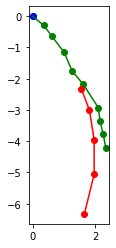

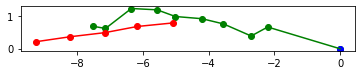

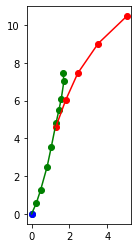

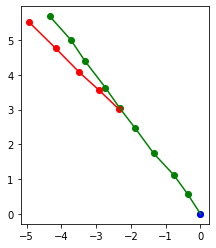

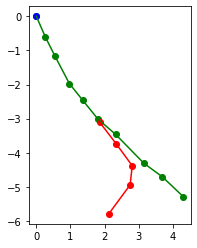

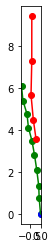

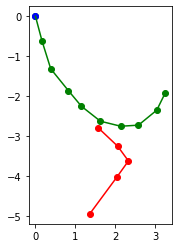

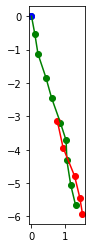

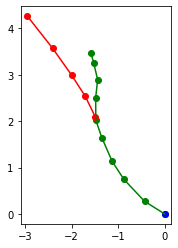

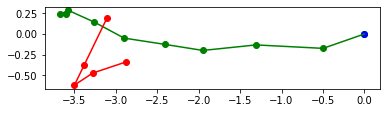

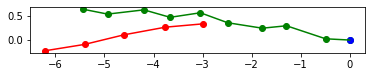

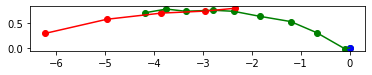

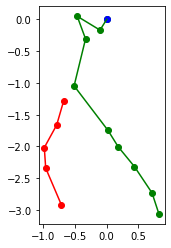

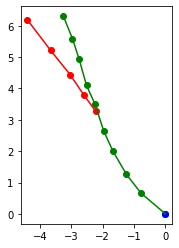

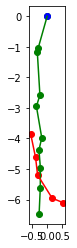

Average FDE:  2.093864784774762


In [27]:
# Creating a 'rolling' prediction, predicting 1 point based on 5 seen points, then another point based
# on 4 seen points and 1 predicted point and so on
all_FDE = []
plotting = True
no_of_plotted_trajectories = 20

for idx, agent_id in enumerate(test_agent_ids):

    seen_x = np.array(data[data['agent_id'] == agent_id].iloc[:5]['pos_x'])
    seen_y = np.array(data[data['agent_id'] == agent_id].iloc[:5]['pos_y'])
    unseen_x = np.array(data[data['agent_id'] == agent_id].iloc[5:10]['pos_x'])
    unseen_y = np.array(data[data['agent_id'] == agent_id].iloc[5:10]['pos_y'])

    rolling_x = np.array(seen_x)
    rolling_y = np.array(seen_y)
    for i in range(5):
        seen_coordinates = np.column_stack((rolling_x, rolling_y))
        pred_x, pred_y = model.predict(np.array([seen_coordinates]))

        rolling_x = np.append(rolling_x[1:], [pred_x[0]])
        rolling_y = np.append(rolling_y[1:], [pred_y[0]])

    FDE = np.sqrt((rolling_x[-1] - unseen_x[-1])**2 + (rolling_y[-1] - unseen_y[-1])**2)
    all_FDE.append(FDE)
    # plot data
    if plotting and idx < no_of_plotted_trajectories:
        plt.axes().set_aspect('equal')

        plt.plot(np.append(seen_x, unseen_x), np.append(seen_y, unseen_y), color='g')
        plt.scatter(np.append(seen_x, unseen_x), np.append(seen_y, unseen_y), color='g')

        plt.plot(rolling_x, rolling_y, color='r')
        plt.scatter(rolling_x, rolling_y, color='r')

        plt.scatter(seen_x[0], seen_y[0], color='b')

        plt.show()

print("Average FDE: ", np.mean(all_FDE))